# Klassifizierung der Fälle für 2013 zum CI-Zeitpunkt

Wir sehen uns mal folgende Eigenschaften der 35&thinsp;px&thinsp;&times;&thinsp;35&thinsp;px-Ausschnitte an:

1. Bedeckungsgrad
2. Großwetterlage
3. mittlere Wolkenhöhe
4. dominaneter Wolkentyp
5. Grauwertkorrelationsmatrixeigenschaften
6. Anteile von niedrigen, mittleren und hohen Wolken.

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from skimage.feature import greycomatrix, greycoprops

from glob import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pickle

import sys
sys.path.append("/vols/satellite/lenk/utils")
import nwcsaf_ct_cmap
ct_cmap, ct_norm, ct_abbrev = nwcsaf_ct_cmap.nwcsaf_ct_cmap()

/vols/satellite/home/lenk/anaconda3/envs/tracking/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
track_path = "/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/cutouts_t0/"

In [7]:
case_files = glob("{}*.nc".format(track_path))

In [14]:
case_data = xr.open_dataset(case_files[5])

In [150]:
case_id = case_files[5].split("/")[-1].split(".")[0]
print(case_id)

20150707_602


## 1. Bedeckungsgrad

Den bestimmen wir aus dem Anteil von unbewölkten Pixeln in der NWC&thinsp;SAF-Wolkenmase (Wert = 1).

In [15]:
def cloud_cover(cma_data):
    cloudiness = len(np.where(cma_data >= 2)[0]) / (cma_data.shape[0]*cma_data.shape[1])
    
    return cloudiness

In [16]:
cloud_cover(case_data['CMa'].data[1])

0.7257142857142858

## 2. Großwetterlage

In [16]:
gwl_data = pd.read_csv("/vols/satellite/home/lenk/data/auxillary_data/GWL.csv")

## 3. Mittlere Wolkenhöhe

In [17]:
np.mean(case_data['CTTH_HEIGHT'][1].data)

4517.224489795918

In [18]:
np.max(case_data['CTTH_HEIGHT'][1].data)

12600.0

## 4. Dominanter Wolkentyp

In [37]:
cloud_types = pd.read_csv("/vols/satellite/home/lenk/utils/nwcsaf_cloud_types2.list",sep=",")

In [21]:
def determine_cloud_fractions(ct_data):
    n_pixels = ct_data.shape[0] * ct_data.shape[1]
    
    # very low
    n_very_low = len(np.where(ct_data==6)[0])
                     
    # low
    n_low = len(np.where(ct_data==8)[0])
    
    # medium
    n_medium = len(np.where(ct_data==10)[0])
    
    # high
    n_high = len(np.where(ct_data==12)[0])
    
    #very_high
    n_very_high = len(np.where(np.logical_and(ct_data>=15,ct_data<19))[0])
                      
    out_dict = {'very_low':n_very_low/n_pixels,
                'low':n_low/n_pixels,
                'medium':n_medium/n_pixels,
                'high':n_high/n_pixels,
                'very_high':n_very_high/n_pixels
               }
    return out_dict                  

## 5. GLCM-Eigenschaften

Vielleicht wäre der Kontrast interessant.

In [135]:
def scale_array_min_max(array_data,range_min=0,range_max=1):
    """
    Scales a array into the chosen range.
    
    Inputs:
    -------
    array_data: numpy array of floats or integers, 2d
        array to scale
    range_min: int or float, default = 0
        minimum value of the range to scale array to,
    range_max: int or float, default = 1
        maximum value of the range to scale array to,
        
    Returns:
    --------
    scaled_array: numpy array of floats, 2d
    """
    # get array extrema
    array_min = np.min(array_data)
    array_max = np.max(array_data)

    # derive conversion parameters
    a = (range_max - range_min) / (array_max - array_min)
    b = range_max - a * array_max

    # scale array
    scaled_array = a * array_data + b
    
    return scaled_array

In [145]:
ir108_gray = np.uint8(scale_array_min_max(np.max(case_data['IR_108'][1])-case_data['IR_108'][1],0,24))
#ir108_gray = np.uint8(np.digitize(ir108_gray, np.arange(0, np.max(ir108_gray),5))) - 1

glcm = greycomatrix(ir108_gray, [1], [0, np.pi/2],symmetric=True,normed=True)
glcm_contrast = greycoprops(glcm, 'contrast')
glcm_homogeneity = greycoprops(glcm,'homogeneity')
glcm_ASM = greycoprops(glcm,'ASM')
glcm_correlation = greycoprops(glcm,'correlation')

In [146]:
print("Kontrast: {}\nHomogenität: {}\nASM: {}\nKorrelation: {}".format(glcm_contrast,glcm_homogeneity,glcm_ASM,glcm_correlation))

Kontrast: [[3.10588235 4.15462185]]
Homogenität: [[0.62245197 0.58913059]]
ASM: [[0.04057588 0.03641515]]
Korrelation: [[0.92463132 0.89838367]]


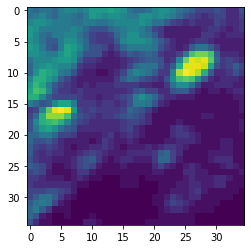

In [147]:
plt.imshow(ir108_gray)

## 6. Räumliche Variabilität

In [148]:
spatial_var = pd.read_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/spatial_var_haci_cases.csv")

In [149]:
spatial_var.iloc[0].case_id

'20080511_1888'

In [154]:
spatial_var.loc[case_id]

KeyError: '20150707_602'

## Für alle HACI-Fälle

In [155]:
# case_files = glob("{}*.nc".format(track_path))

In [447]:
# case_id = []
# cloudiness = []
# gwl_types = []
# ctth_mean = []
# ctth_max = []
# ct_dominating = []
# very_low_fraction = []
# low_fraction = []
# medium_fraction = []
# high_fraction = []
# very_high_fraction = []
# mean_contrast = []
# mean_homogeneity = []
# mean_ASM = []
# mean_correlation = []

In [448]:
# case_files.sort()

In [449]:
# for cf in case_files:
    try:
        case_data = xr.open_dataset(cf)
        case_id.append(cf.split("/")[-1].split(".")[0])
          
        case_date = pd.Timestamp(case_data.time[1].data)
        gwl_types.append(gwl_data[gwl_data.date==int(case_date.strftime("%Y%m%d"))].GWL.values[0])

        cloudiness.append(cloud_cover(case_data['CMa'].data[1]))
        
        ctth_mean.append(int(np.rint(np.mean(case_data['CTTH_HEIGHT'].data[1]))))
        ctth_max.append(int(np.rint(np.max(case_data['CTTH_HEIGHT'].data[1]))))

        ct, count = np.unique(case_data['CT'].data[1],return_counts=True)
        max_id = np.where(count == np.max(count))
        dominant_ct = int(ct[max_id][0])
        ct_dominating.append(cloud_types.abbrev.loc[cloud_types.type == dominant_ct].values[0])

        cloud_fractions = determine_cloud_fractions(case_data['CT'].data[1])
        very_low_fraction.append(cloud_fractions['very_low'])
        low_fraction.append(cloud_fractions['low'])
        medium_fraction.append(cloud_fractions['medium'])
        high_fraction.append(cloud_fractions['high'])
        very_high_fraction.append(cloud_fractions['very_high'])

        ir108_gray = np.uint8(scale_array_min_max(np.max(case_data['IR_108'][1])-case_data['IR_108'][1],0,24))

        glcm = greycomatrix(ir108_gray, [1], [0, np.pi/2], symmetric=True, normed=True)
        glcm_contrast = greycoprops(glcm, 'contrast')
        glcm_homogeneity = greycoprops(glcm,'homogeneity')
        glcm_ASM = greycoprops(glcm,'ASM')
        glcm_correlation = greycoprops(glcm,'correlation')
        
        mean_contrast.append(np.mean(glcm_contrast))
        mean_homogeneity.append(np.mean(glcm_homogeneity))
        mean_ASM.append(np.mean(glcm_ASM))
        mean_correlation.append(np.mean(glcm_correlation))
    
    except Exception as e:
        print("FEHLER {} bei Fall {}.".format(e,cf))

In [450]:
# data_dict = {'case ID':case_id,
#              'cloud fraction':cloudiness,
#              'GWL': gwl_types,
#              'mean CTTH': ctth_mean,
#              'max. CTTH': ctth_max,
#              'dominating CT':ct_dominating,
#              'fraction very low clouds': very_low_fraction,
#              'fraction low clouds': low_fraction,
#              'fraction medium high clouds': medium_fraction,
#              'fraction high clouds': high_fraction,
#              'fraction very high clouds': very_high_fraction,
#              'mean GLCM contrast': mean_contrast,
#              'mean GLCM homogeneity':mean_homogeneity,
#              'mean GLCM ASM':mean_ASM,
#              'mean GLCM correlation':mean_correlation}

In [451]:
# case_properties = pd.DataFrame(data_dict)

In [452]:
# case_properties.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_properties.csv",index=False,float_format='%.2f')

In [454]:
# case_properties.head()

,case ID,cloud fraction,GWL,mean CTTH,max. CTTH,dominating CT,fraction very low clouds,fraction low clouds,fraction medium high clouds,fraction high clouds,fraction very high clouds,mean GLCM contrast,mean GLCM homogeneity,mean GLCM ASM,mean GLCM correlation
0,20080528_1242,0.967347,SEZ,6949,12000,sem. above lower cl.,0.120816,0.105306,0.035102,0.000000,0.586939,3.155882,0.509391,0.015370,0.933004
1,20080530_1321,0.903673,SEZ,5951,11800,broken cl.,0.013878,0.056327,0.119184,0.143673,0.319184,4.103782,0.542019,0.013583,0.959025
2,20080531_1559,0.701224,SEZ,5410,12200,land,0.203265,0.043265,0.008980,0.004082,0.168980,2.019748,0.771380,0.086978,0.989043
3,20080531_1581,0.934694,SEZ,4000,11200,v. low cl.,0.432653,0.088980,0.006531,0.209796,0.118367,2.329832,0.711642,0.059864,0.982005
4,20080602_1440,0.915918,HNFZ,4477,10000,sem. above lower cl.,0.114286,0.083265,0.029388,0.000000,0.508571,5.168067,0.484537,0.012015,0.879262


In [455]:
# case_properties = case_properties[case_properties['dominating CT']!='not proc.']

In [456]:
# years = []
# months = []
# for i, row in case_properties.iterrows():
#     years.append(int(row['case ID'][0:4]))
#     months.append(int(row['case ID'][4:6]))

In [457]:
# case_properties = case_properties.assign(year = years)
# case_properties = case_properties.assign(month = months)

In [458]:
# case_properties.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_properties.csv",index=False,float_format='%.2f')

In [3]:
case_properties = pd.read_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_properties.csv")

In [4]:
case_properties

,case ID,cloud fraction,GWL,mean CTTH,max. CTTH,dominating CT,fraction very low clouds,fraction low clouds,fraction medium high clouds,fraction high clouds,fraction very high clouds,mean GLCM contrast,mean GLCM homogeneity,mean GLCM ASM,mean GLCM correlation,year,month,CTTH_ratio,isolated,ice_clouds
0,20080528_1242,0.97,SEZ,6949,12000,sem. above lower cl.,0.12,0.11,0.04,0.00,0.59,3.16,0.51,0.02,0.93,2008,5,0.58,0,1
1,20080530_1321,0.90,SEZ,5951,11800,broken cl.,0.01,0.06,0.12,0.14,0.32,4.10,0.54,0.01,0.96,2008,5,0.50,0,1
2,20080531_1559,0.70,SEZ,5410,12200,land,0.20,0.04,0.01,0.00,0.17,2.02,0.77,0.09,0.99,2008,5,0.44,1,0
3,20080531_1581,0.93,SEZ,4000,11200,v. low cl.,0.43,0.09,0.01,0.21,0.12,2.33,0.71,0.06,0.98,2008,5,0.36,1,0
4,20080602_1440,0.92,HNFZ,4477,10000,sem. above lower cl.,0.11,0.08,0.03,0.00,0.51,5.17,0.48,0.01,0.88,2008,6,0.45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,20150831_603,0.33,SWA,627,10800,land,0.11,0.01,0.00,0.00,0.05,1.93,0.72,0.11,0.81,2015,8,0.06,1,0
511,20150831_617,0.36,SWA,912,11400,land,0.09,0.03,0.00,0.00,0.08,3.30,0.67,0.08,0.82,2015,8,0.08,1,0
512,20150901_545,0.60,TM,2070,7600,land,0.12,0.11,0.04,0.00,0.19,5.46,0.56,0.03,0.91,2015,9,0.27,0,0
513,20150901_873,0.76,TM,3907,11600,land,0.11,0.10,0.05,0.03,0.27,2.73,0.58,0.04,0.94,2015,9,0.34,1,0


In [5]:
phi = (1+np.sqrt(5)) / 2
print(phi)
width = 14
height =  width / phi

1.618033988749895


In [8]:
pic_path = "/vols/satellite/home/lenk/proj/2019-01_trackingstudie/pics/Fallklassifikation/"

# Analyse

Dann sehen wir uns doch mal an, ob sich was interessantes zeigt.

## GWL

In [6]:
gwl_count = case_properties.GWL.value_counts()

In [7]:
years = case_properties.year.unique()

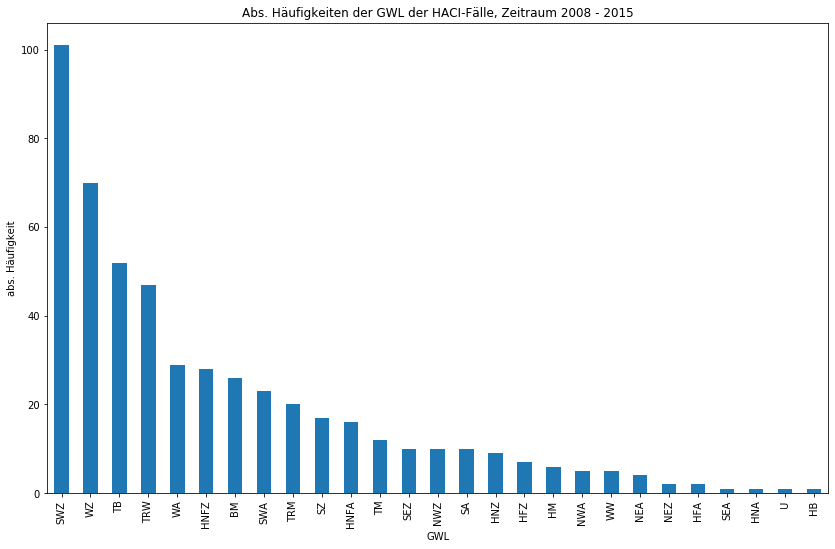

In [12]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
gwl_count.plot(kind='bar',ax=ax)
ax.set_title("Abs. Häufigkeiten der GWL der HACI-Fälle, Zeitraum {} - {}".format(years.min(),years.max()))
ax.set_ylabel("abs. Häufigkeit")
ax.set_xlabel("GWL")
plt.savefig("{}/GWL_HACI_abs_Häufigkeit.pdf".format(pic_path))

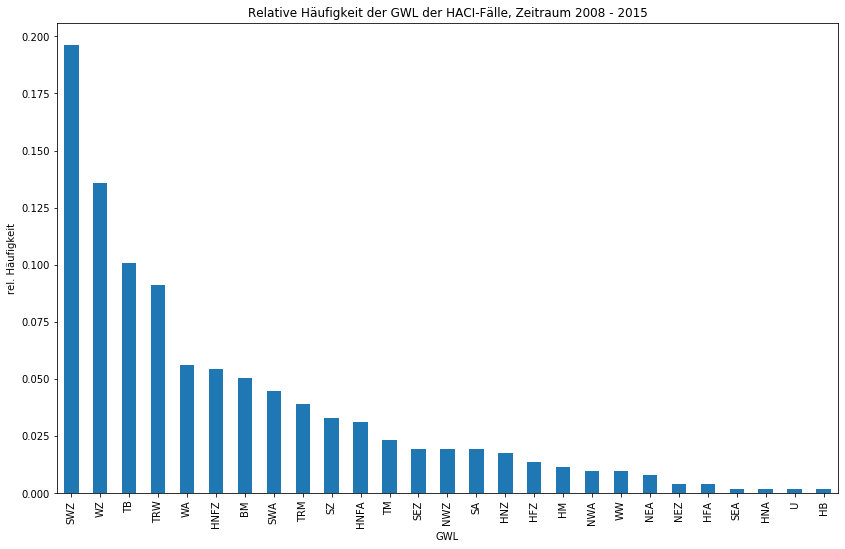

In [13]:
gwl_rel = gwl_count / gwl_count.sum()
fig,ax = plt.subplots(1,1,figsize=(width,height))
gwl_rel.plot(kind='bar',ax=ax)
ax.set_title("Relative Häufigkeit der GWL der HACI-Fälle, Zeitraum {} - {}".format(years.min(),years.max()))
ax.set_ylabel("rel. Häufigkeit")
ax.set_xlabel("GWL")
plt.savefig("{}/GWL_HACI_rel_Häufigkeit.pdf".format(pic_path))

Wie zu erwarten, kommen die meisten konvektiven Ereignisse bei zyklonalen Großwetterlagen mit südwestlich bis westlicher Anströmung vor. Dann folgen eher antizyklonale Großwetterlagen, mit eher lokaler Konvektion.

Das Bild kann allerdings auch dadurch zu stande kommen, dass die zyklonalen Großwetterlagen mit südwestlicher bis westlicher Anströmung einfach häufiger vorkommen. Das sollten wir prüfen.

### GWL-Häufigkeit

In [17]:
gwl_count_total = gwl_data.GWL.value_counts()

In [18]:
gwl_count_total_relative = gwl_count_total / gwl_count_total.sum()

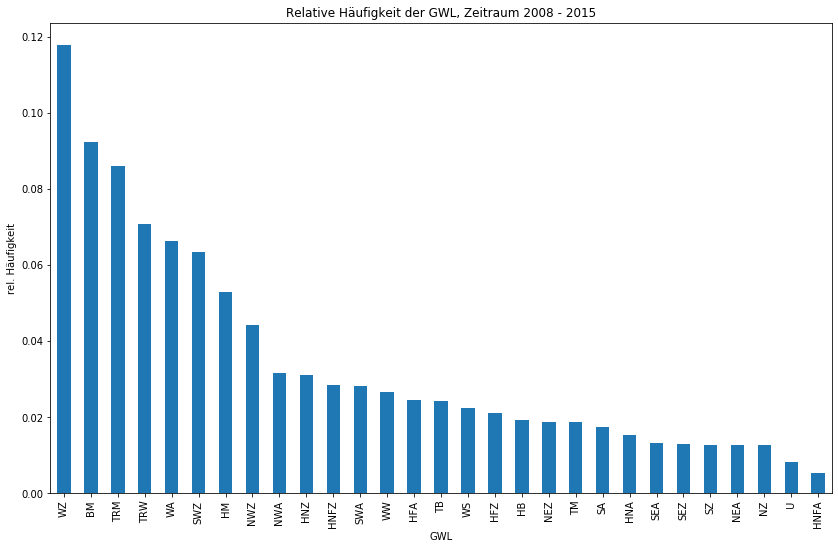

In [19]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
gwl_count_total_relative.plot(kind='bar',ax=ax)
ax.set_title("Relative Häufigkeit der GWL, Zeitraum {} - {}".format(years.min(),years.max()))
ax.set_ylabel("rel. Häufigkeit")
ax.set_xlabel("GWL")
plt.savefig("{}/GWL_rel_Häufigkeit.pdf".format(pic_path))

Die Häufigkeitsverteilung der GWL allein unterscheidet sich von der der GWL der HACI-Fälle. Es gibt also einige Wetterlagen, die häufiger HACI-Objekte hervorbringen. Vielleicht sieht man das, wenn man das Verhältnis aus den GWL-Häufigkeiten und den GWL-Häufigkeiten der HACI-Fälle bildet.

In [20]:
gwl_ratio = gwl_count / gwl_count_total

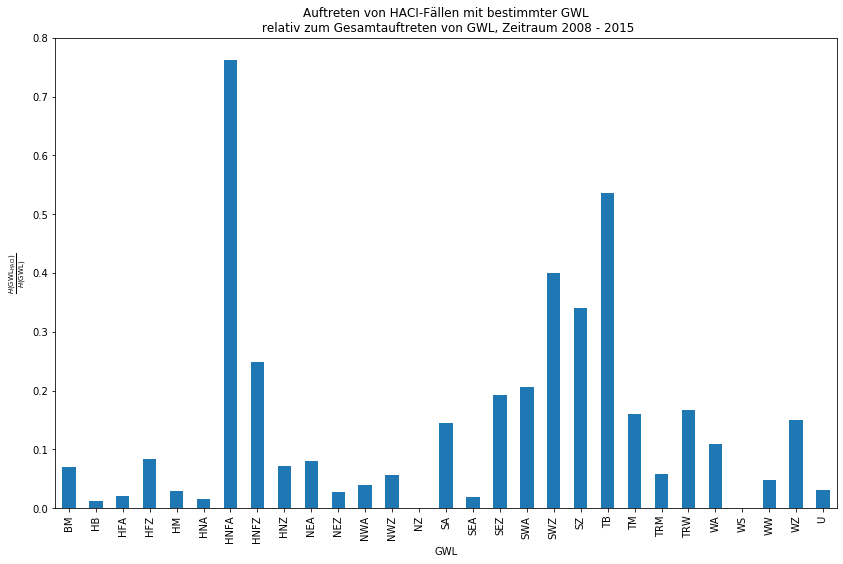

In [24]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
gwl_ratio.plot(kind='bar',ax=ax)
ax.set_title("Auftreten von HACI-Fällen mit bestimmter GWL\n relativ zum Gesamtauftreten von GWL, Zeitraum {} - {}".format(years.min(),years.max()))
ax.set_xlabel("GWL")
ax.set_ylabel(r"$\frac{H(\mathrm{GWL}_\mathrm{HACI})}{H(\mathrm{GWL})}$")
plt.savefig("{}/GWL_HACI_GWL.pdf".format(pic_path))

Es gibt ein paar GWL, an denen besonders viele HACI-Objekte auftreten. Das sind die Wetterlagen mit Hoch-Nordmeer-Fennoskandien, SWZ, SZ, TB, TM.

### GWL nach Jahren

In [193]:
gwl_year = case_properties.groupby(['GWL','year'])['GWL'].count()

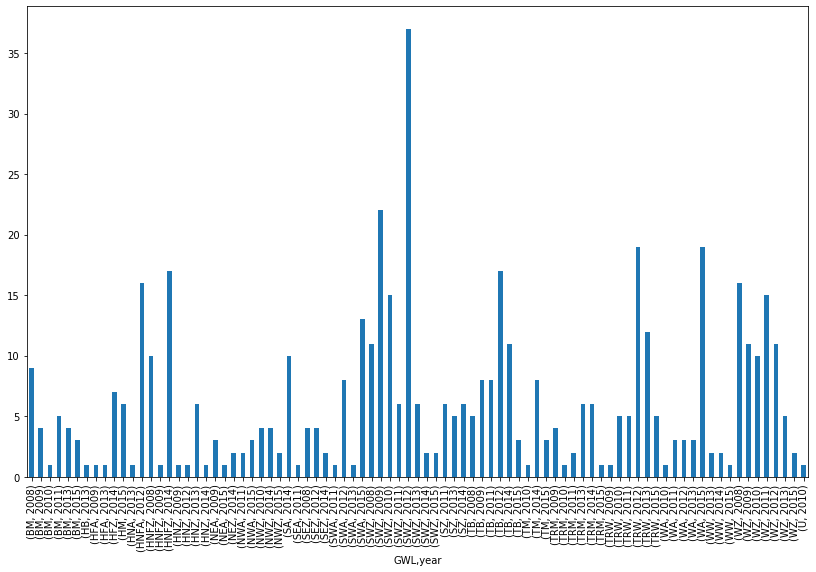

In [194]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
gwl_year.plot(kind='bar',ax=ax)

## GWL und mittlere Wolkenoberkantenhöhe

In [26]:
def boxplot_sorted(df, by, column,**kwargs):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(rot=90)

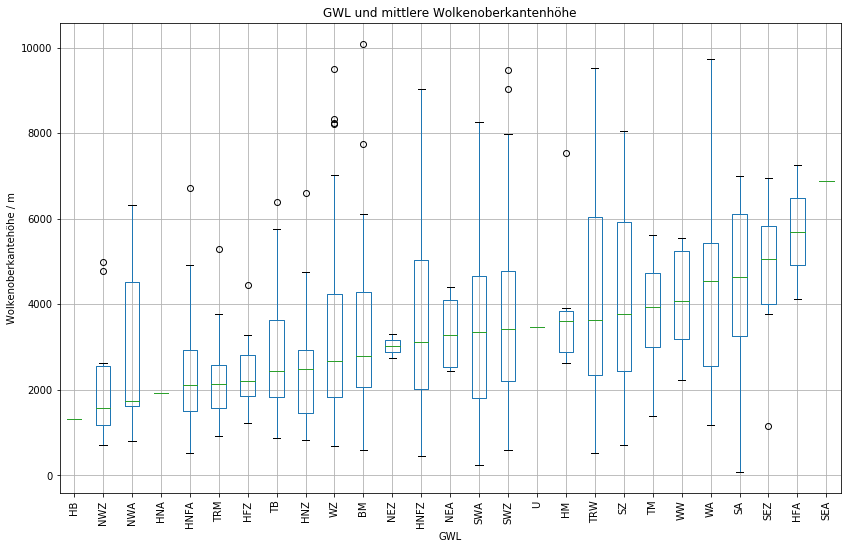

In [28]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'GWL','mean CTTH',ax=ax)
ax.set_ylabel("Wolkenoberkantehöhe / m")
ax.set_title("GWL und mittlere Wolkenoberkantenhöhe")
ax.set_xlabel("GWL")
plt.savefig("{}/GWL_MW_CTTH.pdf".format(pic_path))

Die mittlere Wolkenhöhe scheint von der GWL im großen ung ganzen unabhängig zu sein. Bei einigen GWL sind die Wolken etwas höher (HFA,SEZ, SEA) und bei einigen etwas niedriger (HFZ, HB, HNA, NEZ, TRM) aber bei den meisten GWL ist die Spannbreite ziemlich groß.

## GWL und maximale Wolkenoberkantenhöhe

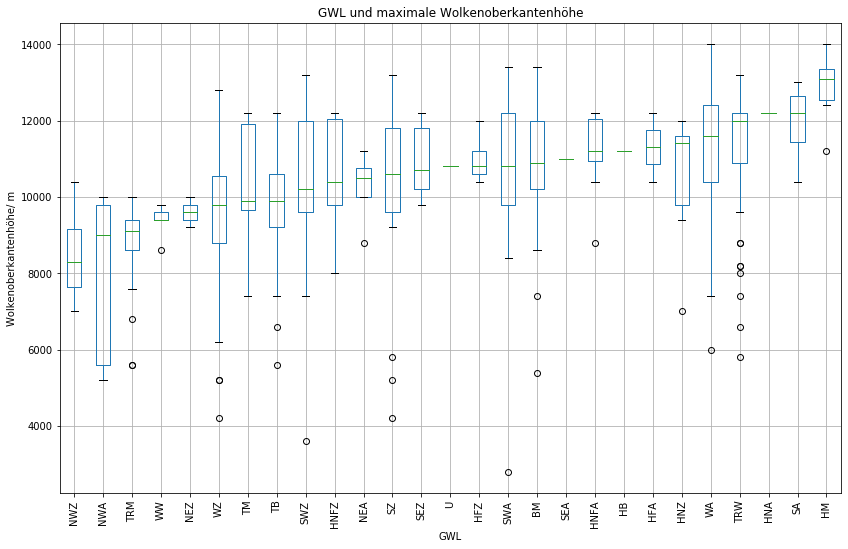

In [29]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'GWL','max. CTTH',ax=ax)
ax.set_ylabel("Wolkenoberkantenhöhe/ m")
ax.set_title("GWL und maximale Wolkenoberkantenhöhe")
ax.set_xlabel("GWL")
plt.savefig("{}/GWL_max_CTTH.pdf".format(pic_path))

Für die maximale Wolkenoberkantenhöhe gilt ähnliches wie für die mittlere Wolkenoberkantenhöhe.

## Dominierende Wolkentypen

### Häufigkeit

Zuerst sehen wir uns mal an, wie häufig die dominierenden Wolkentypen sind.

In [31]:
dct_count = case_properties['dominating CT'].value_counts() / np.sum(case_properties['dominating CT'].value_counts())

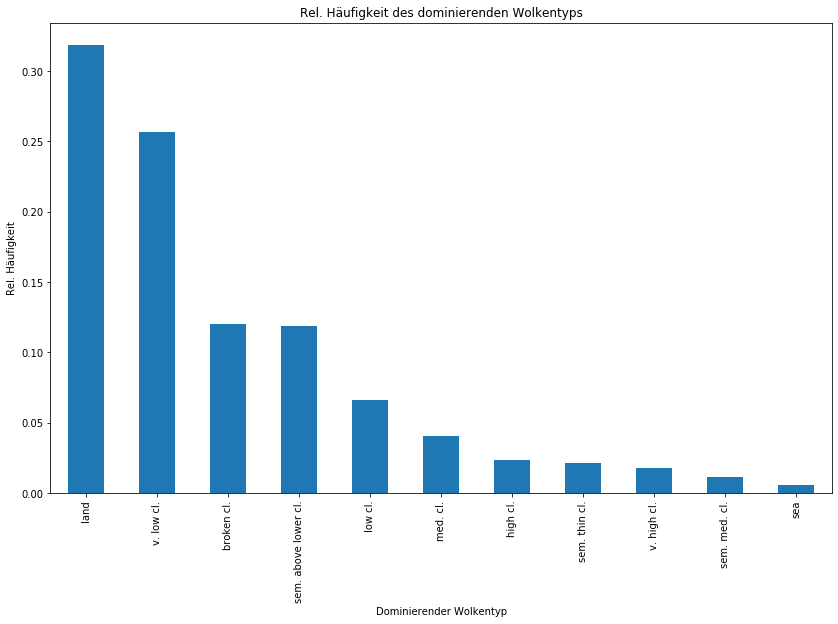

In [32]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
dct_count.plot(kind='bar',ax=ax)
ax.set_title("Rel. Häufigkeit des dominierenden Wolkentyps")
ax.set_ylabel("Rel. Häufigkeit")
ax.set_xlabel("Dominierender Wolkentyp")
plt.savefig("{}/CT_rel.pdf".format(pic_path))

Das sieht doch ganz gut aus. In den meisten Fällen dominieren wolkenfreie Bereiche. Also sollten die Fälle da relativ isoliert sein. Auch die Fälle mit den dominierenden sehr niedrigen, niedrigen und mittelhohen Wolken und den Subpixelwolken sollten eher unproblematische isolierte Fälle sein. Die Fälle, bei denen semitransparente Wolken dominieren sind dann wahrscheinlich eher die problematischeren Fälle mit Randentwicklungen.

### Dominierender Wolkentyp und der Bewölkungsgrad

Um diese Vermutung etwas zu untermauern, sehen wir uns mal das Zusammenspiel zwischen Bewölkungsgrad und dominierendem Wolkentypen an.

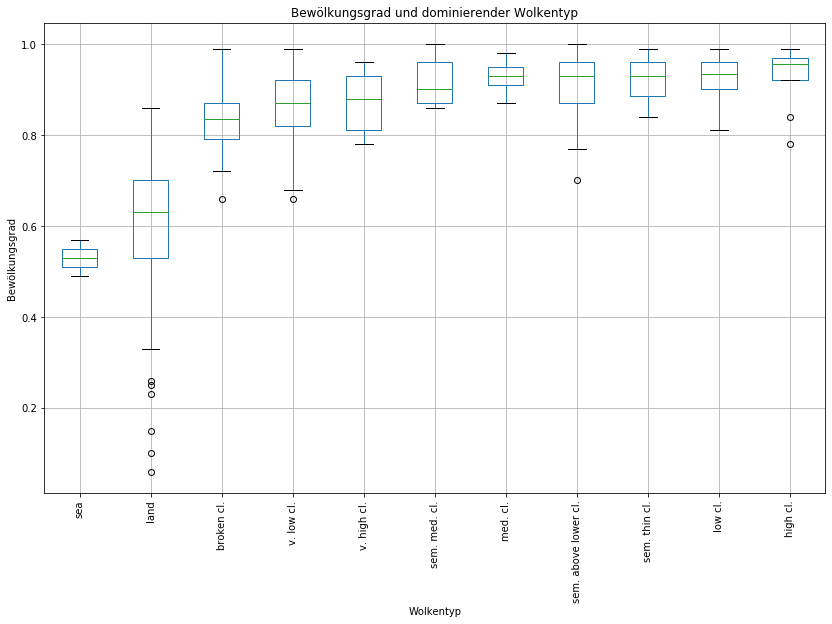

In [34]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','cloud fraction',ax=ax,rot=90)
ax.set_ylabel("Bewölkungsgrad")
ax.set_title("Bewölkungsgrad und dominierender Wolkentyp")
ax.set_xlabel("Wolkentyp")
plt.savefig("{}/CT_CF.pdf".format(pic_path))

Wie zu erwarten, ist der Bedeckungsgrad bei den Fällen mit dominierendem Wolkentyp wolkenfrei am niedrigsten. Dann folgen die Subpixelwolken. Ansonsten scheint der Bedeckungsgrad vom Wolkentyp relativ unabhängig zu sein.

### Dominierender Wolkentyp und Wolkenhöhe

Es ist zu erwarten, dass der dominierende Wolkentyp und die Wolkenhöhe korrelieren. Dann sehen wir uns das mal an.

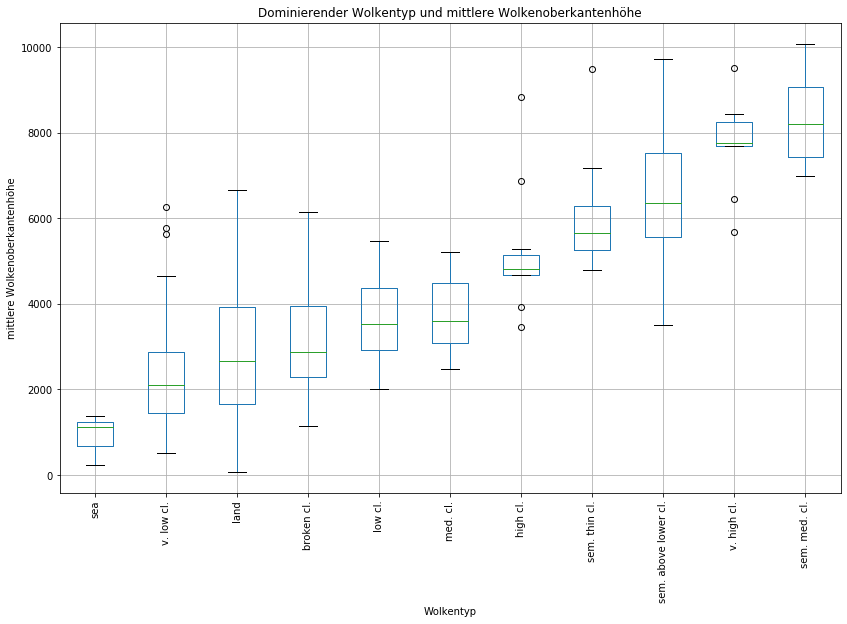

In [35]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','mean CTTH',ax=ax,rot=90)
ax.set_ylabel("mittlere Wolkenoberkantenhöhe")
ax.set_title("Dominierender Wolkentyp und mittlere Wolkenoberkantenhöhe")
ax.set_xlabel("Wolkentyp")
plt.savefig("{}/CT_MW_CTTH.pdf".format(pic_path))

Die mittlere Wolkenhöhe und der Wolkentyp passen logisch ganz gut zusammen. Die mittlere Wolkenhöhe der sehr niedrigen Wolken ist geringer als die der niedrigen usw. Interessant ist, dass die niedrigste mittlere Wolkenhöhe bei den Fällen auftritt, die vom Wolkentyp wolkenfreies Meer dominiert werden. Die Spannbreiten der mittleren Wolkenhöhe sind für die unterschiedlichen dominierenden Wolkentypen recht unterschiedlich, aber z.T. recht groß. Das ist wahrscheinlich darauf zurückzuführen, dass in dem Ausschnitt auch noch andere Wolkentypen vorhanden sind. Inbesondere die Spannbreite der mittleren Wolkenhöhe bei wolkenlosem Land ist recht hoch. Hier sind wahrscheinlich relativ viele verschiedene Wolkentypen vorhanden.

Interessant wäre auch, sich anzusehen, wie sich dominierender Wolkentyp, mittlere Wolkenhöhe und Bewölkungsgrad verhalten.

### Dominierender Wolkentyp, mittlere Wolkenhöhe und Bewölkungsgrad

In [38]:
cts = [cloud_types[cloud_types.abbrev==c['dominating CT']].type.values[0] for i,c in case_properties.iterrows()]

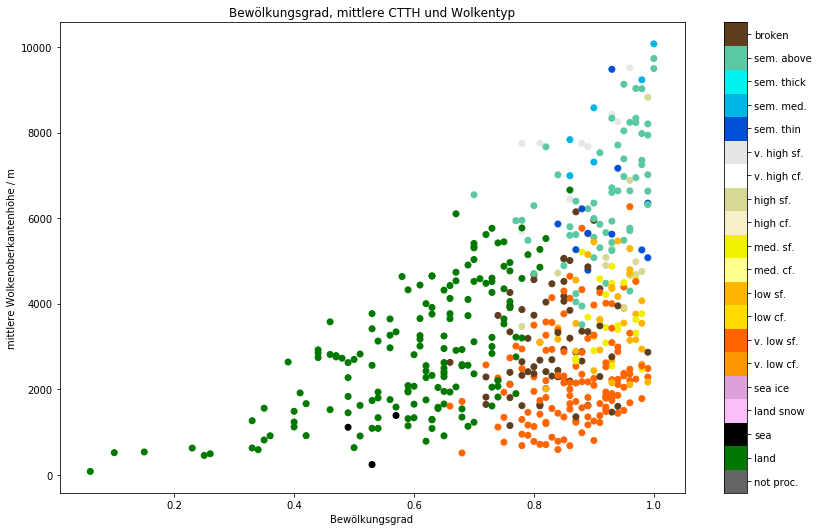

In [39]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = case_properties['mean CTTH'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_title("Bewölkungsgrad, mittlere CTTH und Wolkentyp")
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("mittlere Wolkenoberkantenhöhe / m")
plt.savefig("{}/CF_MW_CTTH_CT.pdf".format(pic_path))

Es sieht so aus, als könnte man die Fälle einigermaßen mit Bewölkungsgrad und mittlerer Wolkenhöhe trennen:

1. Die eher isolierten Fälle, bei denen wolkenfreie wolkentypen dominieren liegen, im Bereich Bewölkungsgrad &leq; 0,8 und mittlere Wolkenhöhe &leq; 6000 m.

2. Die Fälle mit den eher problematischen hohen dünnen Eiswolken liegen im Bereich Bewölkungsgrad > 0,8 und mittlere Wolkenhöhe > 4000 m. Es gibt hier also eine Teilüberlappung mit den isolierten Fällen.

3. Die eher nicht isolierten Fälle, bei denen niedrige Wolken dominieren, liegen im Bereich Bewölkungsgrad > 0,7 und mittlere Wolkenhöhe &leq; 6000 m.

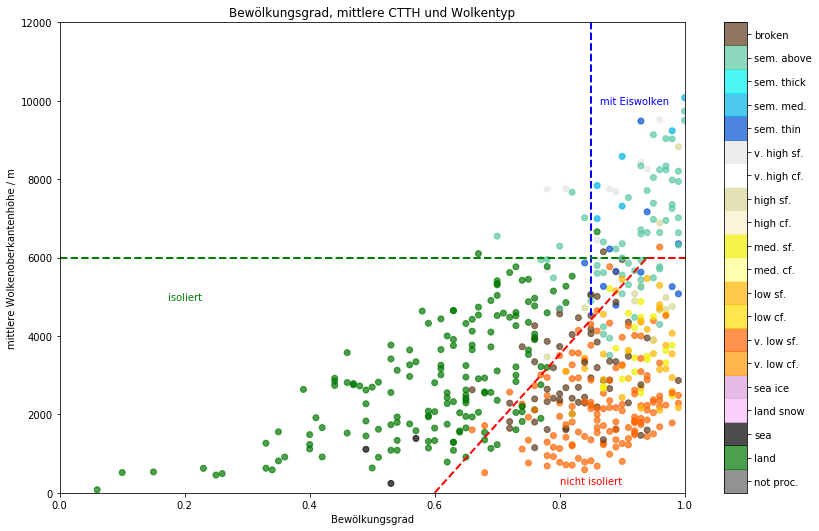

In [40]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = case_properties['mean CTTH'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm,alpha=0.7)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_title("Bewölkungsgrad, mittlere CTTH und Wolkentyp")
ax.add_line(Line2D((0.85,0.85),(12000,4500),color='blue',linestyle='dashed',linewidth=2))
ax.add_line(Line2D((0.0,0.94),(6000,6000),color='green',linestyle='dashed',linewidth=2))
ax.add_line(Line2D((0.6,0.94),(0,6000),color='red',linestyle='dashed',linewidth=2))
ax.add_line(Line2D((0.94,1),(6000,6000),color='red',linestyle='dashed',linewidth=2))
ax.set_ylim(0,12000)
ax.set_xlim(0,1)
ax.text(0.2, 5000, 'isoliert', horizontalalignment='center',
  verticalalignment='center',color='green')
ax.text(0.92, 10000, 'mit Eiswolken', horizontalalignment='center',
  verticalalignment='center',color='blue')
ax.text(0.85, 300, 'nicht isoliert', horizontalalignment='center',
  verticalalignment='center',color='red')

ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("mittlere Wolkenoberkantenhöhe / m")
plt.savefig("{}/CF_MW_CTTH_CT2.pdf".format(pic_path))

Das sieht gant nach einem Fall für SVM aus. Aber vielleicht kann man die Überlappungsbereiche besser trennen, wenn man die maximale Wolkenhöhe betrachtet.

### Maximale Wolkenhöhe

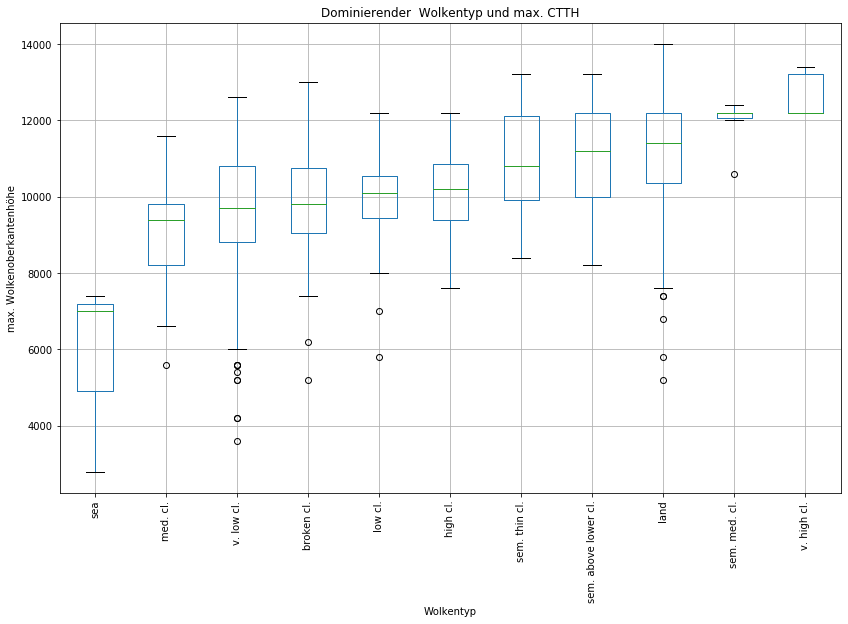

In [41]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','max. CTTH',ax=ax,rot=90)
ax.set_ylabel("max. Wolkenoberkantenhöhe")
ax.set_title("Dominierender  Wolkentyp und max. CTTH")
ax.set_xlabel("Wolkentyp")
plt.savefig("{}/CT_max_CTTH.pdf".format(pic_path))

Wenn man die maximale, statt der mittleren, Wolkenhöhe betrachtet, stechen die Unterschiede nicht mehr ganz so hervor. Hier zeigt sich, dass neben den dominierenden Wolkentypen wohl oft auch höhere Wolken in dem Ausschnitt vorhanden sind. Vielleicht sieht man mehr, wenn man den Wolkentyp in bezug auf maximale Wolkenhöhe und Bewölkungsgrad betrachtet.

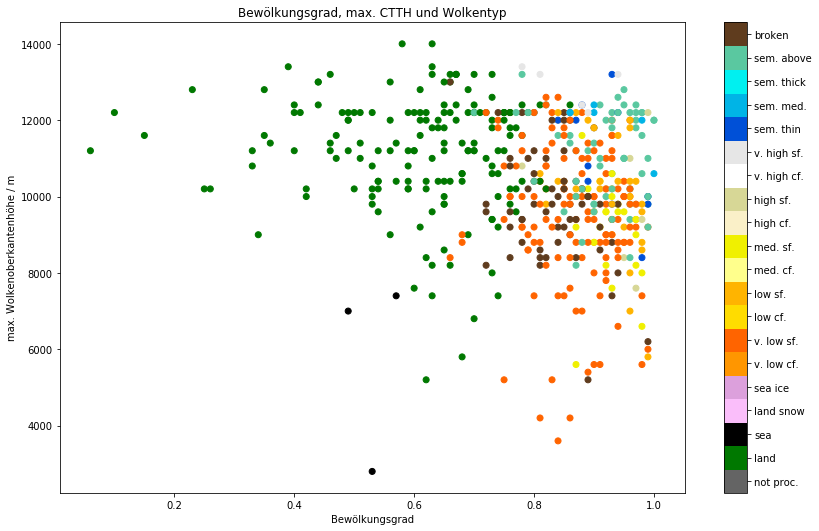

In [42]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = case_properties['max. CTTH'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("max. Wolkenoberkantenhöhe / m")
ax.set_title("Bewölkungsgrad, max. CTTH und Wolkentyp")
plt.savefig("{}/CF_max_CTTH_CT.pdf".format(pic_path))

Die Trennung mit der Wolkenhöhe funktioniert hier nicht mehr so gut, wie bei der mittleren Wolkenhöhe. Aber die Differenz der maximalen zur mittleren Wolkenhöhe ist bei den eher isolierten Fällen groß, während sie für die problematischeren Fälle eher gering ist. Ähnliches gilt für den Quotienten aus mittlerer und maximaler Wolkenhöhe. Wenn der Quotient klein ist, ist der Unterschied groß und wenn er gegen eins geht ist der Unterschied klein.

In [43]:
ctth_diff = case_properties['max. CTTH'] - case_properties['mean CTTH']
ctth_quot = case_properties['mean CTTH'] / case_properties['max. CTTH']

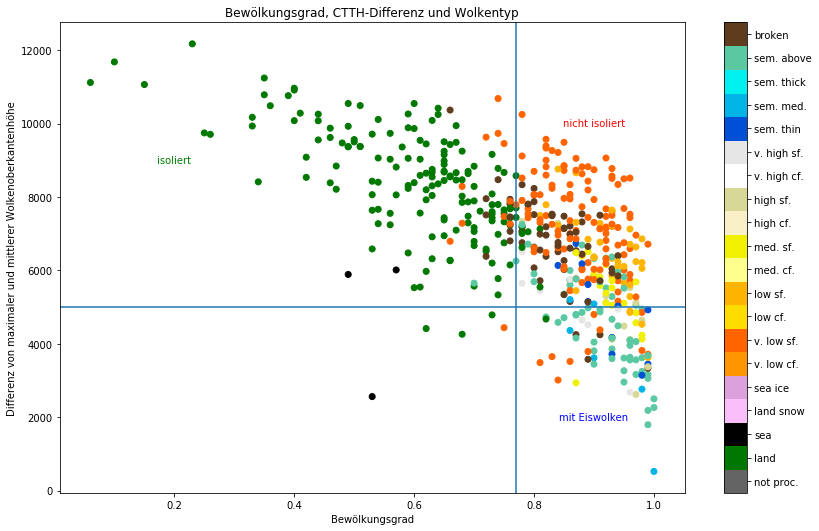

In [44]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = ctth_diff,
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("Differenz von maximaler und mittlerer Wolkenoberkantenhöhe")
ax.set_title("Bewölkungsgrad, CTTH-Differenz und Wolkentyp")
ax.axhline(5000)
ax.axvline(0.77)

ax.text(0.2, 9000, 'isoliert', horizontalalignment='center',
  verticalalignment='center',color='green')
ax.text(0.9,2000, 'mit Eiswolken', horizontalalignment='center',
  verticalalignment='center',color='blue')
ax.text(0.9, 10000, 'nicht isoliert', horizontalalignment='center',
  verticalalignment='center',color='red')
plt.savefig("{}/CF_CTTH-Diff_CT.pdf".format(pic_path))

Bei der Differenz kann man die isolierten und nicht isolierten Fälle einfacher trennen, weil die Trenneung durch den Bewölkungsgrad einfacher ist.

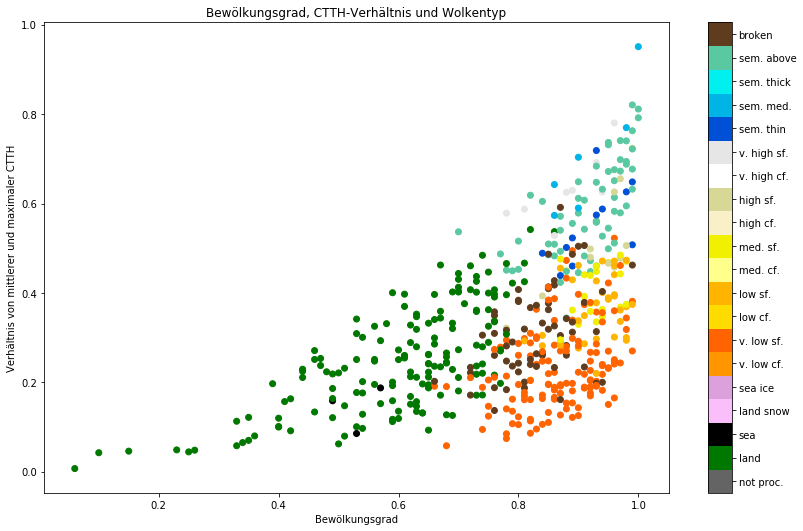

In [46]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = ctth_quot,
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("Verhältnis von mittlerer und maximaler CTTH")
ax.set_title("Bewölkungsgrad, CTTH-Verhältnis und Wolkentyp")
plt.savefig("{}/CF_CTTH-Quot_CT.pdf".format(pic_path))

Der Quotient aus der mittleren und maximalen Wolkenhöhe staucht die Streuung der Fälle ohne Eiswolken etwas mehr zusammen, sodass die Trennung zwischen Fällen mit Eis- und ohne dominierende Eiswolken einfacher wird. Aber im Grunde sieht das ähnlich aus, wie bei der mittleren Wolkenhöhe.

Vielleicht wird die Einteilung mit GLCM-Größen besser.

## GLCM-Maße

Die GLCM-Maße werden berechnet, indem die Wertunterscheide eines Pixels zu seinen Nachbarn in einer bestimten Richtung bestimmt wird. Für die Trennung von isolierten und nicht isolierten Fällen sollte das ganz hilfreich sein, weil:

1. isolierte Fälle einen relativ hohen Kontrast haben sollten, weil im Ausschnitt Wolken und Boden vorhanden sind,
2. die Homogenität der isolierten Fälle deswegen geringer sein sollte,
3. die Regelmäßigkeit der isolierten Fälle deswegen geringer sein sollte und
4. die GLCM-Korrelation keiner sein sollte, weil mehr Bereiche mit unterschiedlichen Grauwerten im Ausschnitt vorhanden sind.

Dann sehen wir uns das doch mal an.

### Kontrast

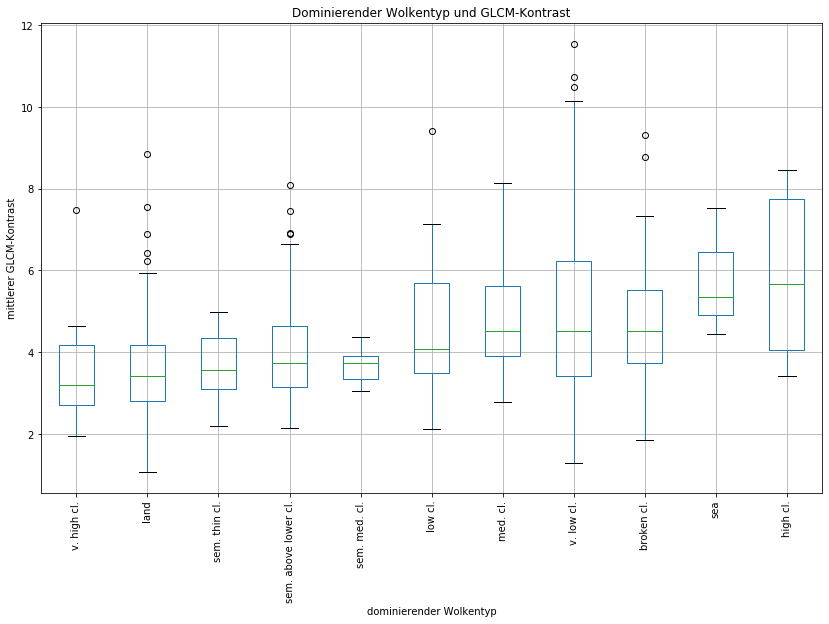

In [47]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','mean GLCM contrast',ax=ax,rot=90)
ax.set_ylabel("mittlerer GLCM-Kontrast")
ax.set_title("Dominierender Wolkentyp und GLCM-Kontrast")
ax.set_xlabel("dominierender Wolkentyp")
plt.savefig("{}/CT_Kontrast.pdf".format(pic_path))

Der mittlere GLCM-Kontrast ist für die meisten Wolkentypen relativ ähnlich. Allerdings ist er für die Fälle, wo wolkenfreies Meer und hohe Wolken dominieren höher als für die anderen Fälle. Das liegt wahrscheinlich daran, dass Inseln oder die Küste mit im Ausschnitt sind. Hohe Wolken und sehr hohe Wolken untersscheiden sich hier deutlich. Vielleicht sind die hohen Wolken kleiner?

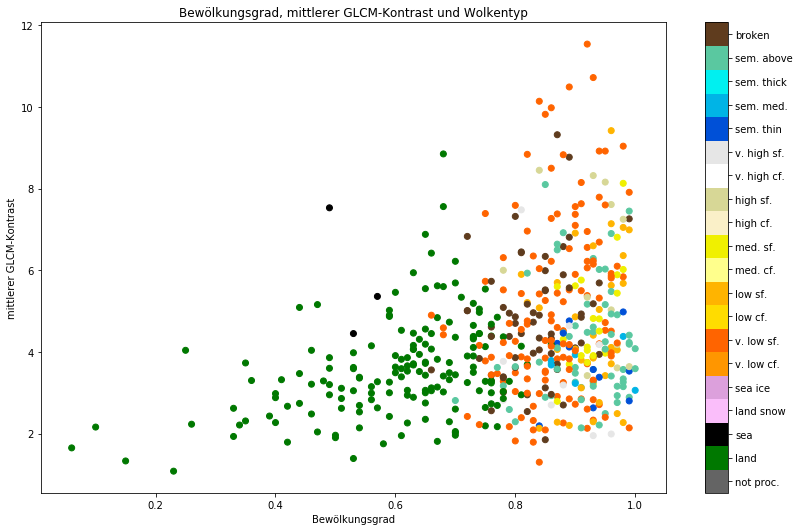

In [48]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = case_properties['mean GLCM contrast'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("mittlerer GLCM-Kontrast")
ax.set_title("Bewölkungsgrad, mittlerer GLCM-Kontrast und Wolkentyp")
plt.savefig("{}/CF_Kontrast_CT.pdf".format(pic_path))

Über den Kontrast lassen sich wahrscheinlich isolierte und nicht isolierte Fälle trennen.

### Homogenität

Die Homogenität sollte sich dem Kontrast entgegen gesetzt verhalten.

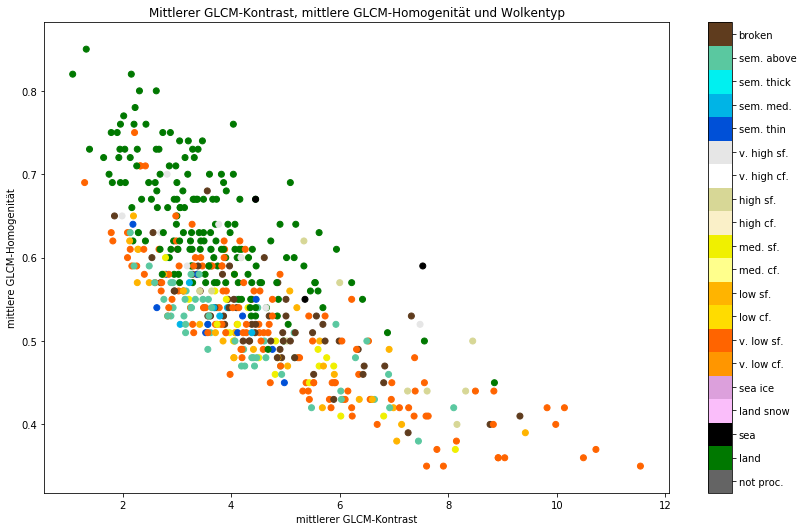

In [49]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['mean GLCM contrast'],
                 y = case_properties['mean GLCM homogeneity'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("mittlerer GLCM-Kontrast")
ax.set_ylabel("mittlere GLCM-Homogenität")
ax.set_title("Mittlerer GLCM-Kontrast, mittlere GLCM-Homogenität und Wolkentyp")
plt.savefig("{}/Kontrast_Homogenität.pdf".format(pic_path))

Wie zu erwarten sind der Kontrast und die Homogenität recht gut negativ korreliert. Aber ein paar Abweichungen gibt es.

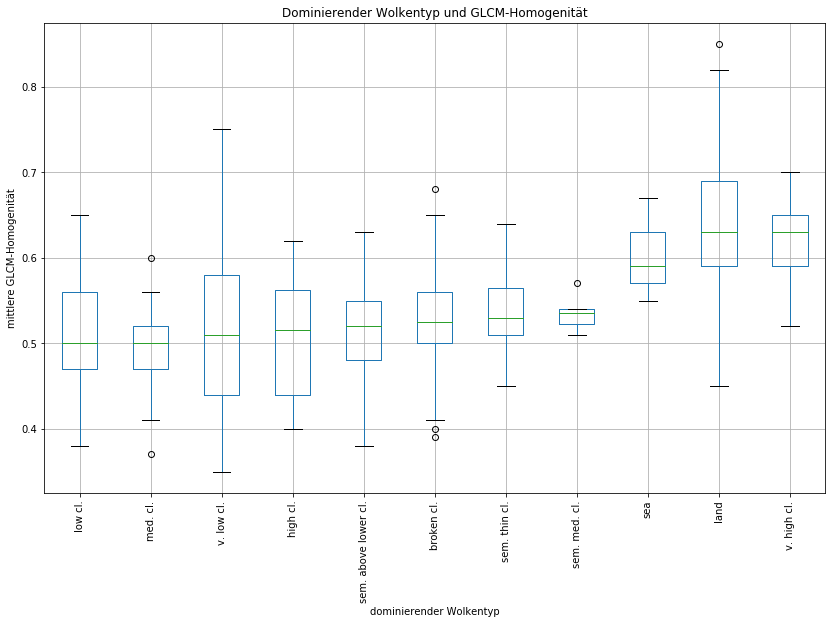

In [50]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','mean GLCM homogeneity',ax=ax,rot=90)
ax.set_ylabel("mittlere GLCM-Homogenität")
ax.set_title("Dominierender Wolkentyp und GLCM-Homogenität")
ax.set_xlabel("dominierender Wolkentyp")
plt.savefig("{}/CT_Homogenität.pdf".format(pic_path))

Erwartungsgemäß sind die wolkenfreien Bereiche homogener als die bewölkten. Die Fälle, die durch sehr hohe Wolken dominiert werden haben auch eine eher hohe Homogenität. Das liegt wahrscheinlich daran, dass hohe Eiswolken auch eher homogen aussehen. Interessant ist, dass das Meer zwar einen hohen Kontrast hat, aber auch sehr homogen ist. Das liegt wahrscheinlich an den Eigenschaften der Wasseroberfläche im thermischen Infrarot.

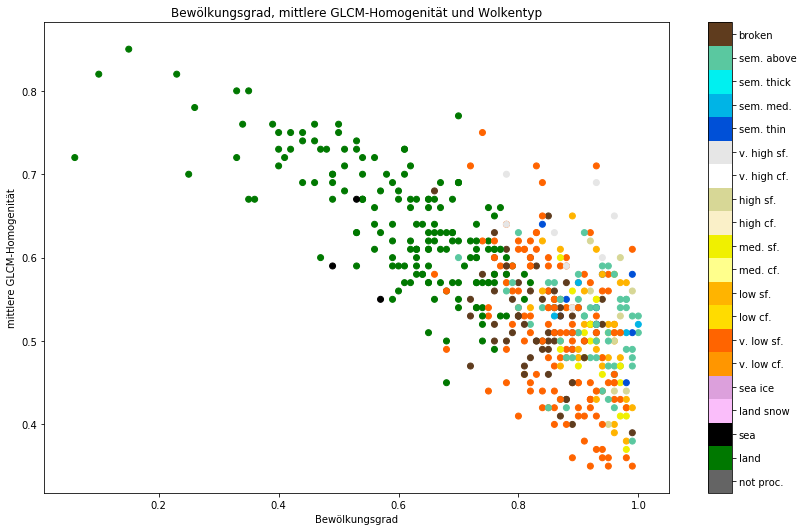

In [51]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = case_properties['mean GLCM homogeneity'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("mittlere GLCM-Homogenität")
ax.set_title("Bewölkungsgrad, mittlere GLCM-Homogenität und Wolkentyp")
plt.savefig("{}/CF_Homogenität_CT.pdf".format(pic_path))

Ähnlich, wie beim Kontrast, könnte man mit der Homogenität die isolierten von den nicht so isolierten Fällen trennen.

### ASM

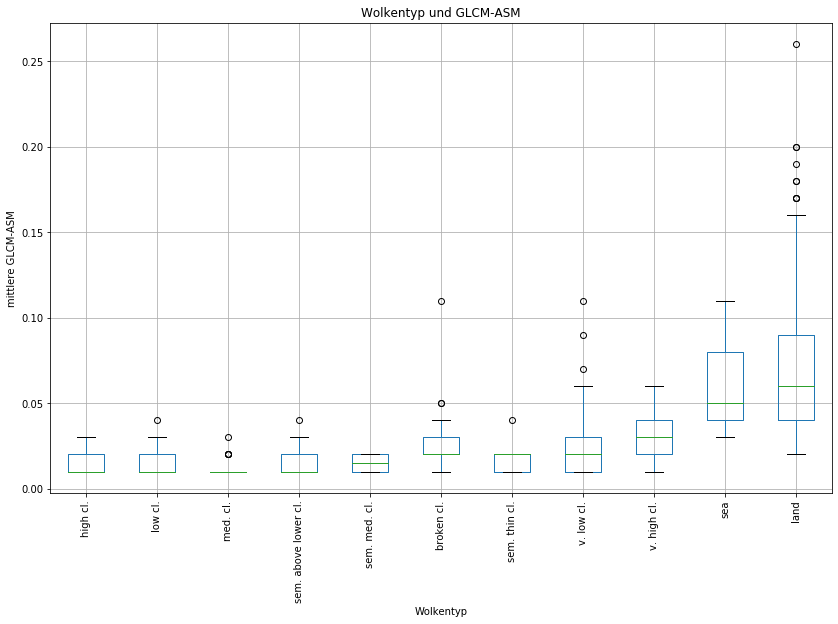

In [52]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','mean GLCM ASM',ax=ax,rot=90)
ax.set_ylabel("mittlere GLCM-ASM")
ax.set_title("Wolkentyp und GLCM-ASM")
ax.set_xlabel("Wolkentyp")
plt.savefig("{}/CT_ASM.pdf".format(pic_path))

Der ASM ist ein Maß für die Regelmäßigkeit des betrachteten Ausschnitts. Die Regelmäßigkeit ist also für die meisten dominierenden Wolkentypen relativ gering, nur die wolkenfreien Bereiche sind regelmäßiger. Vielleicht stechen deshalb die isolierten Fälle etwas heraus? Das sollten wir uns mal ansehen.

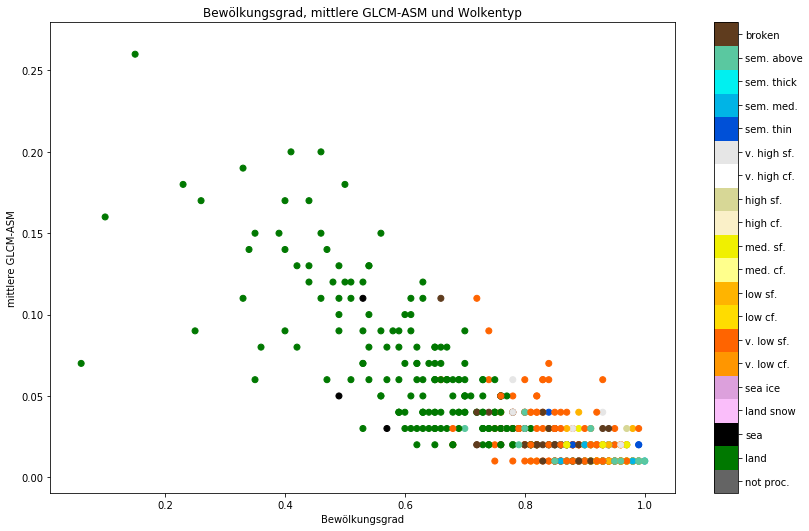

In [53]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['cloud fraction'],
                 y = case_properties['mean GLCM ASM'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("Bewölkungsgrad")
ax.set_ylabel("mittlere GLCM-ASM")
ax.set_title("Bewölkungsgrad, mittlere GLCM-ASM und Wolkentyp")
plt.savefig("{}/CF_ASM_CT.pdf".format(pic_path))

Die meisten nicht isolierten Fälle drängen sich im Bereich von ASM &leq; 0.05 und Bewölkungsgrad > 0.75. Die Streuung der isolierten Fälle ist in ASM-Richtung deutlich größer.

### GLCM-Korrelation

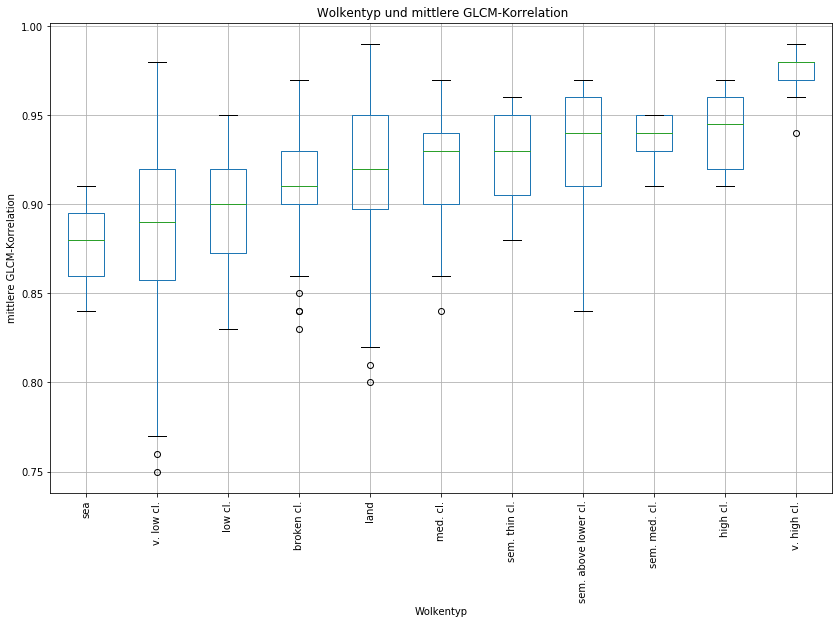

In [54]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
boxplot_sorted(case_properties,'dominating CT','mean GLCM correlation',ax=ax,rot=90)
ax.set_ylabel("mittlere GLCM-Korrelation")
ax.set_title(" Wolkentyp und mittlere GLCM-Korrelation")
ax.set_xlabel("Wolkentyp")
plt.savefig("{}/CT_Korrelation.pdf".format(pic_path))

Die GLCM-Korrrelation verhält sich anders, als die anderen GLCM-Maße. Es gibt hier eine Zunahme mit der Wolkenhöhe, nur unterbrochen vom wolkenfreien Land. 

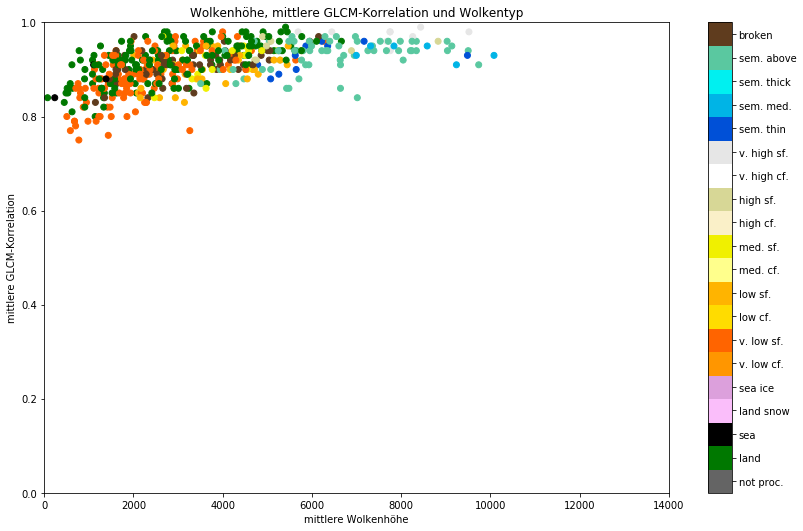

In [56]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['mean CTTH'],
                 y = case_properties['mean GLCM correlation'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("mittlere Wolkenhöhe")
ax.set_ylabel("mittlere GLCM-Korrelation")
ax.set_title("Wolkenhöhe, mittlere GLCM-Korrelation und Wolkentyp")
ax.set_xlim(0,14000)
ax.set_ylim(0,1)
plt.savefig("{}/CTTH_Korrelation_CT.pdf".format(pic_path))

Es gibt eine Korrelation zwischen mittlerer Wolkenhöhe und GLCM Korrelation, allerdings ist sie nicht linear und das wolkenfreie Land liegt im gleichen Bereich, wie mittelhohe Wolken.

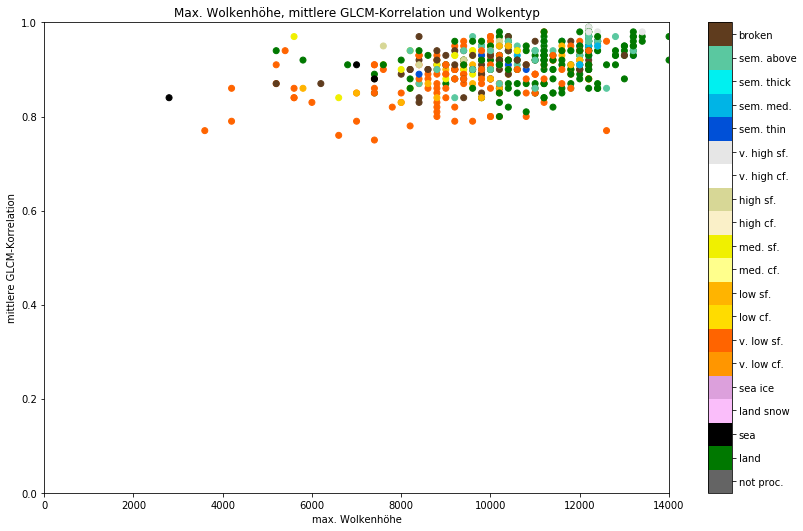

In [57]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['max. CTTH'],
                 y = case_properties['mean GLCM correlation'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("max. Wolkenhöhe")
ax.set_ylabel("mittlere GLCM-Korrelation")
ax.set_title("Max. Wolkenhöhe, mittlere GLCM-Korrelation und Wolkentyp")
ax.set_xlim(0,14000)
ax.set_ylim(0,1)
plt.savefig("{}/max_CTTH_Korrelation_CT.pdf".format(pic_path))

In [ ]:
ax.set_xlim(0,14000)
ax.set_ylim(0,1)

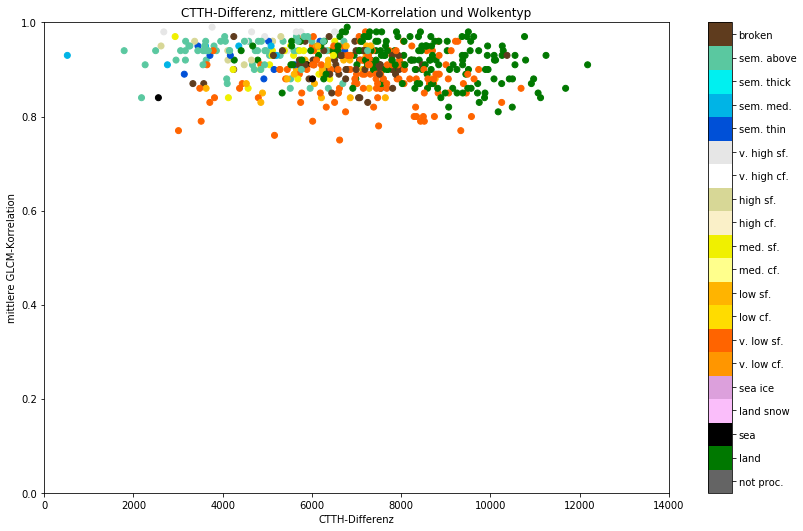

In [58]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = ctth_diff,
                 y = case_properties['mean GLCM correlation'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("CTTH-Differenz")
ax.set_ylabel("mittlere GLCM-Korrelation")
ax.set_title("CTTH-Differenz, mittlere GLCM-Korrelation und Wolkentyp")
ax.set_xlim(0,14000)
ax.set_ylim(0,1)
plt.savefig("{}/CTTH-Diff_Korrrelation_CT.pdf".format(pic_path))

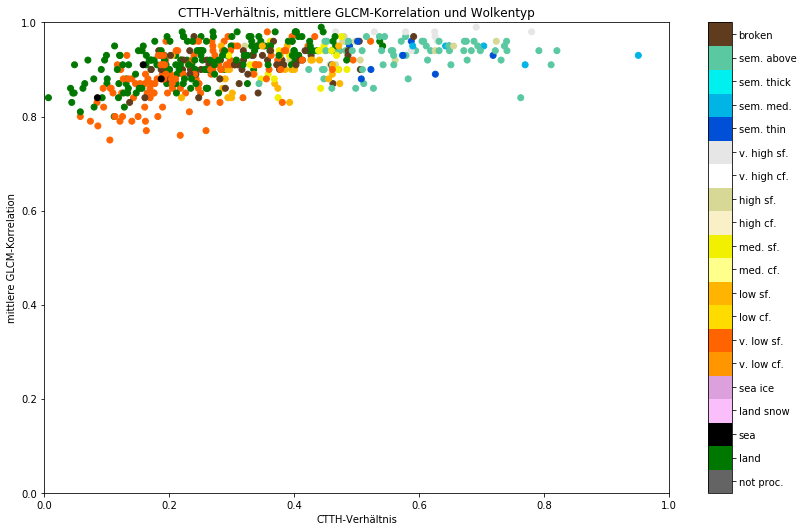

In [60]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = ctth_quot,
                 y = case_properties['mean GLCM correlation'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("CTTH-Verhältnis")
ax.set_ylabel("mittlere GLCM-Korrelation")
ax.set_title("CTTH-Verhältnis, mittlere GLCM-Korrelation und Wolkentyp")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.savefig("{}/CTTH-Quot_Korrelation_CT.pdf".format(pic_path))

## Klassifizierung

Für die Klassifizierung der Fälle eignen sich wahrscheinlich die GLCM-Homogenität, um isolierte und nicht so isolierte Fälle zu trennen, und das Verhältnis aus maximaler und mittlerer Wolkenoberkantenhöhe, um Fälle mit hohen Eiswolken von welchen ohne zu trennen.

In [465]:
case_properties = case_properties.assign(CTTH_ratio = ctth_quot)

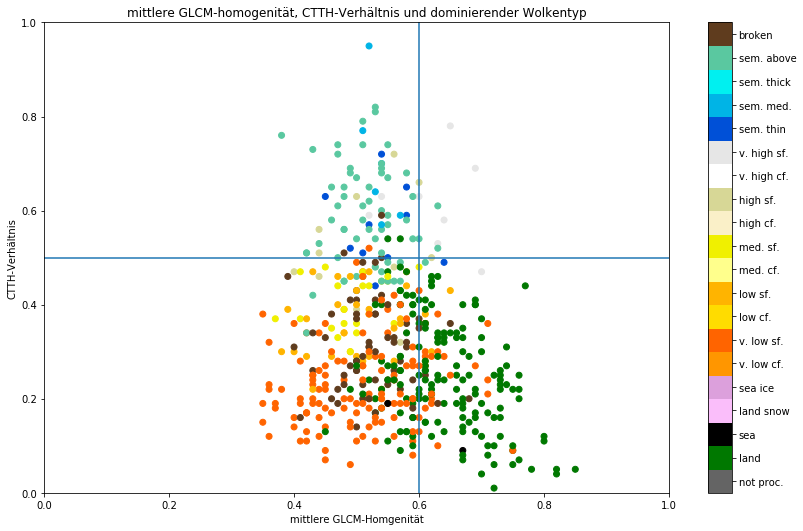

In [63]:
fig,ax = plt.subplots(1,1,figsize=(width,height))
cax = ax.scatter(x = case_properties['mean GLCM homogeneity'],
                 y = case_properties['CTTH_ratio'],
                 c = cts,
                 cmap = ct_cmap, norm = ct_norm)

cbar = fig.colorbar(cax,ticks=np.arange(0,20))
labels = np.arange(0,20,1)
loc = labels + .5
cbar.set_ticks(loc)
cbar.ax.set_yticklabels(ct_abbrev.tolist())
ax.set_xlabel("mittlere GLCM-Homgenität")
ax.set_ylabel("CTTH-Verhältnis")
ax.set_title("mittlere GLCM-homogenität, CTTH-Verhältnis und dominierender Wolkentyp")
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.axhline(0.5)
ax.axvline(0.6)
plt.savefig("{}/CTTH-Quot_Homogenität_CT.pdf".format(pic_path))

Ein CTTH-Verhältnis von 0,5 und ein GLCM-Kontrast von 0,6 könnten akzeptable Schwellwerte sein.

In [470]:
case_properties.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_properties.csv",index=False,float_format="%.2f")

In [471]:
case_properties.head()

,case ID,cloud fraction,GWL,mean CTTH,max. CTTH,dominating CT,fraction very low clouds,fraction low clouds,fraction medium high clouds,fraction high clouds,fraction very high clouds,mean GLCM contrast,mean GLCM homogeneity,mean GLCM ASM,mean GLCM correlation,year,month,CTTH_ratio
0,20080528_1242,0.967347,SEZ,6949,12000,sem. above lower cl.,0.120816,0.105306,0.035102,0.000000,0.586939,3.155882,0.509391,0.015370,0.933004,2008,5,0.579083
1,20080530_1321,0.903673,SEZ,5951,11800,broken cl.,0.013878,0.056327,0.119184,0.143673,0.319184,4.103782,0.542019,0.013583,0.959025,2008,5,0.504322
2,20080531_1559,0.701224,SEZ,5410,12200,land,0.203265,0.043265,0.008980,0.004082,0.168980,2.019748,0.771380,0.086978,0.989043,2008,5,0.443443
3,20080531_1581,0.934694,SEZ,4000,11200,v. low cl.,0.432653,0.088980,0.006531,0.209796,0.118367,2.329832,0.711642,0.059864,0.982005,2008,5,0.357143
4,20080602_1440,0.915918,HNFZ,4477,10000,sem. above lower cl.,0.114286,0.083265,0.029388,0.000000,0.508571,5.168067,0.484537,0.012015,0.879262,2008,6,0.447700


In [472]:
isolated = []
ice_clouds = []

for i, case in case_properties.iterrows():
    if case.CTTH_ratio <= 0.5:
        ice_clouds.append(0)
    else:
        ice_clouds.append(1)
        
    if case['mean GLCM homogeneity'] >= 0.57:
        isolated.append(1)
    else:
        isolated.append(0)

In [474]:
case_properties = case_properties.assign(isolated = isolated)
case_properties = case_properties.assign(ice_clouds = ice_clouds)

In [475]:
case_properties.to_csv("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_properties.csv",index=False,float_format="%.2f")

In [476]:
cases_2013 = case_properties[case_properties.year==2013]

In [477]:
cases_2013.to_latex("/vols/satellite/home/lenk/proj/2019-01_trackingstudie/data/case_properties_2013.tex",index=False,float_format='%.2f')